# 4. Evaluation Metrics for Classification

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [5]:
df = pd.read_csv('../03-classification/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

### 4.2 Accuracy and dummy model

In [12]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [15]:
scores = []
for t in thresholds:
    churn_decision = (y_pred >= t)
    accuracy_score = (y_val == churn_decision).mean()
    scores.append(accuracy_score)

scores

[0.2739531582682754,
 0.5088715400993612,
 0.5911994322214337,
 0.6664300922640171,
 0.7097232079489,
 0.7388218594748048,
 0.7601135557132718,
 0.7721788502484032,
 0.7849538679914834,
 0.7934705464868701,
 0.8034066713981547,
 0.801277501774308,
 0.794889992902768,
 0.7863733144073811,
 0.765791341376863,
 0.7444996451383961,
 0.7345635202271115,
 0.7260468417317246,
 0.7260468417317246,
 0.7260468417317246,
 0.7260468417317246]

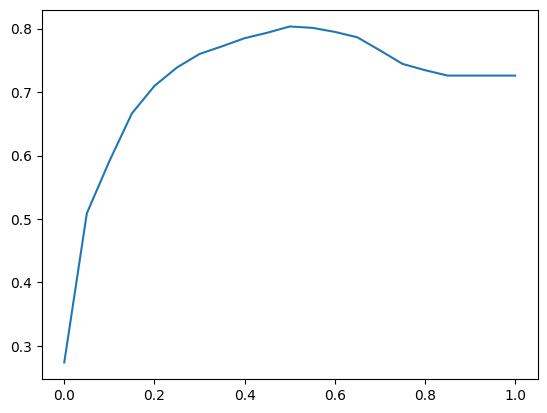

In [18]:
plt.plot(thresholds, scores)

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [20]:
scores = [accuracy_score(y_val, y_pred >= t) for t in thresholds]

In [23]:
from collections import Counter
Counter(y_pred >= 1)

Counter({False: 1409})

# Confusion matrix

In [24]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [25]:
t = 0.5
predicted_positive = (y_pred >= t)
predicted_negative = (y_pred < t)

In [28]:
tp = (predicted_positive & actual_positive).sum()
tn = (predicted_negative & actual_negative).sum()

In [29]:
fp = (predicted_positive & actual_negative).sum()
fn = (predicted_negative & actual_positive).sum()

In [30]:
tp, tn, fp, fn

(210, 922, 101, 176)

In [32]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [36]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

# Precision and Recall

### Precision

Fraction of positive predictions that are correct  

Eg Fraction of prisoners that are actually guilty (ie commited a crime)


In [38]:
precision = tp / (tp + fp)
precision

0.6752411575562701

### Recall

Fraction of correctly identified positive examples

Eg Fraction of imprisoned out of all who commited the crime

In [40]:
recall = tp /(tp + fn)
recall

0.5440414507772021

# ROC curve

Receiver Operating Characteristic

is a graphical representation used in binary classification to assess the performance of a classification model or classifier.


It illustrates the trade-off between the model's true positive rate (sensitivity or recall) and its false positive rate as you vary the decision threshold for classifying positive and negative instances.

True Positive Rate (TPR) or Sensitivity: This is the ratio of correctly predicted positive instances (true positives) to the total number of actual positive instances

TPR = True Positives / (True Positives + False Negatives)


False Positive Rate (FPR): This is the ratio of incorrectly predicted positive instances (false positives) to the total number of actual negative instances.

FPR = False Positives / (False Positives + True Negatives)



In [41]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [43]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [44]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    predicted_positive = (y_pred >= t)
    predicted_negative = (y_pred < t)
    
    tp = (predicted_positive & actual_positive).sum()
    tn = (predicted_negative & actual_negative).sum()

    fp = (predicted_positive & actual_negative).sum()
    fn = (predicted_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [47]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [61]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

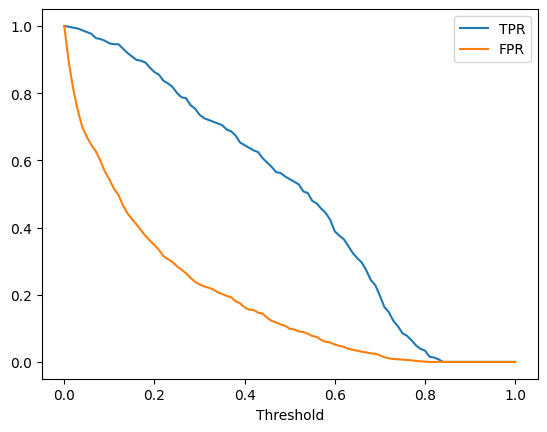

In [62]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.xlabel('Threshold')
plt.legend()